<a href="https://colab.research.google.com/github/AntarikshVerma/Pytorch_Learn/blob/main/minist_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Creating Convolutional Network Layer


#####TOPIC TO LEARN
1.   CONVOLUTIONAL LAYER
2.   POOLING LAYER



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline



In [ ]:
#convert minist image file into tensors 4 dimentionals (# of images, height, width , color channel)
transform = transforms.ToTensor()

In [ ]:
#Train Data
train_data= datasets.MNIST(root='cnn_data', train = True,download = True, transform = transform)

In [ ]:
#Test data

test_data= datasets.MNIST(root='cnn_data', train = False, download = True, transform = transform)

In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: cnn_data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
#create a small batch size for images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)


In [ ]:
# Define Convolutional Model
# Describe convolutional layer and whats it is doing  (Example for 2 layer)
conv1= nn.Conv2d(in_channels= 1,out_channels=6,kernel_size=3,stride=1)
# 6 output is input in this layer conv 2
conv2= nn.Conv2d(6,16, 3, 1)

In [ ]:
# Grab 1 MINIST data
for i, (x_train, y_train) in enumerate(train_data):
  break

In [ ]:
x_train.shape

torch.Size([1, 28, 28])

In [ ]:
# Make tensor 4D (1 batch pf 1 image of 28*28)
x=x_train.view(1,1,28,28)

In [ ]:
# Perform first convolution
x=F.relu(conv1(x)) #Rectifier Linear unit function



In [ ]:
# single image with 6 is a flter we asked for and 26*26 is the size , original was 28*28 it is reduced to 26*26 since we havent given any padding
x.shape

torch.Size([1, 6, 26, 26])

In [ ]:
# Pass through the pooling layer
x= F.max_pool2d(x,2,2) # kernal of 2 and stride of 2



In [ ]:
x.shape

torch.Size([1, 6, 13, 13])

In [ ]:
# Second convolutional layer
x= F.relu(conv2(x)) # No padding in conv2 ,  due to this it will loose 2px around outside of image  which is not USABLE in Minsit image

In [ ]:
x.shape

torch.Size([1, 16, 11, 11])

In [ ]:
x=F.max_pool2d(x,2,2)


In [ ]:
#Another POOLING lAYER  (11/2 =5.5 )
x.shape

torch.Size([1, 16, 5, 5])

In [ ]:
#Model Class

class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1= nn.Conv2d(1,6,3,1)
    self.conv2= nn.Conv2d(6,16,3,1)
    # Fully connected layer // End of CNN , it should be fully connected layer
    self.fc1= nn.Linear(5*5*16,120 ) # 120 is arbitrary value and 5*5*16 from Step 61
    self.fc2= nn.Linear(120,84)
    self.fc3= nn.Linear(84,10)

  def forward(self,X):
    #First Pass
    X= F.relu(self.conv1(X))
    X= F.max_pool2d(X,2,2)

    # Second Pass
    X= F.relu(self.conv2(X))
    X= F.max_pool2d(X,2,2)

    #Re-view to Flatten it out
    X = X.view(-1,16*5*5) #-1 represent we can vary the batch size

    #Fully connected Layer
    X= F.relu(self.fc1(X))
    X= F.relu(self.fc2(X))
    X= self.fc3(X) # Do not need relu for last one since its last one
    return F.log_softmax(X, dim=1)


In [ ]:
#Create an instance of our model
torch.manual_seed(41)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# Loss function optmizer
criterion= nn.CrossEntropyLoss()
optmizer= torch.optim.Adam(model.parameters(), lr= 0.001) # Smaller the leaning rate , longer to take train the model


In [ ]:
import time
start_time=time.time()

# Create variable to track things
epochs=5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loops of Epochs
for i in range(epochs):
  trn_corr = 0
  test_corr = 0

  #Train
  for b,(x_train,y_train) in enumerate(train_loader):
         b+=1 # Start from batch 1
         y_pred = model(x_train) #Get predicted value form traning set.No flattened
         loss= criterion(y_pred,y_train) # How off we are? Compare the prediction of correct answers in y_train

         predicted = torch.max(y_pred.data,1)[1] # Add up the # of correct prediction
         batch_corr = (predicted == y_train).sum()  # How many we got corrcted from this batch
         trn_corr+= batch_corr  # Keep Track as we go along

         #Update our parameters
         optmizer.zero_grad()
         loss.backward()
         optmizer.step()

         #Print our result

         if b%600 == 0:
             print(f'Epoch: {i}, Batch :{b}, Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

    #Test
  with torch.no_grad():  #We dont upgrade our weight and bias with train data
    for b, (x_test,y_test) in enumerate(test_loader):
      y_val=model(x_test)
      predicted= torch.max(y_val.data,1)[1] # Adding up correct prediction
      test_corr +=(predicted ==y_test).sum() #T=1, F=0 and Sum away


  loss = criterion(y_val,y_test)
  test_losses.append(loss)
  test_correct.append(test_corr)

current_time=time.time()
total=current_time-start_time
print(f'Training took : {total/60 } !!!')



Epoch: 0, Batch :600, Loss: 0.00036099221324548125
Epoch: 0, Batch :1200, Loss: 0.0001712304074317217
Epoch: 0, Batch :1800, Loss: 0.0005378525820560753
Epoch: 0, Batch :2400, Loss: 0.027378559112548828
Epoch: 0, Batch :3000, Loss: 0.0002596829435788095
Epoch: 0, Batch :3600, Loss: 8.657989383209497e-05
Epoch: 0, Batch :4200, Loss: 0.00040106248343363404
Epoch: 0, Batch :4800, Loss: 1.2349883036222309e-05
Epoch: 0, Batch :5400, Loss: 0.00046615247265435755
Epoch: 0, Batch :6000, Loss: 0.000162848416948691
Epoch: 1, Batch :600, Loss: 6.399912672350183e-05
Epoch: 1, Batch :1200, Loss: 0.0002539866545703262
Epoch: 1, Batch :1800, Loss: 0.0003175207821186632
Epoch: 1, Batch :2400, Loss: 8.683211490279064e-05
Epoch: 1, Batch :3000, Loss: 0.00015392867499031126
Epoch: 1, Batch :3600, Loss: 0.12387670576572418
Epoch: 1, Batch :4200, Loss: 0.00015394852380268276
Epoch: 1, Batch :4800, Loss: 0.00032526275026611984
Epoch: 1, Batch :5400, Loss: 0.08193918317556381
Epoch: 1, Batch :6000, Loss: 1.2

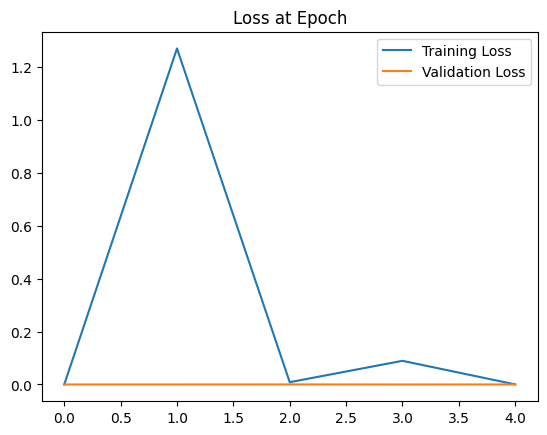

In [ ]:
# Graph the loss at epoch
train_losses= [tl.item() for tl in train_losses]
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Validation Loss")
plt.title("Loss at Epoch")
plt.legend()


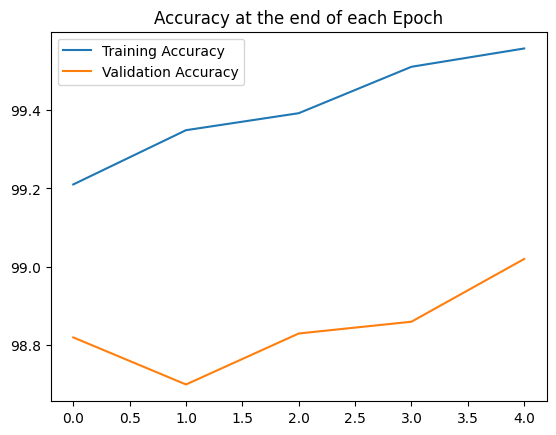

In [ ]:
#Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label="Training Accuracy")
plt.plot([t/100 for t in test_correct], label="Validation Accuracy")
plt.title("Accuracy at the end of each Epoch")
plt.legend()




In [ ]:
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

In [ ]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()


In [ ]:
# Did for correct
correct.item()/len(test_data)*100

99.02

##Testing Of Model

In [ ]:
# Grab an image
test_data[1978] # Tensor with an image in it...at end, it shows the label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [ ]:

# Grab just the data
test_data[1978][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [ ]:
# Reshape it
test_data[1978][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

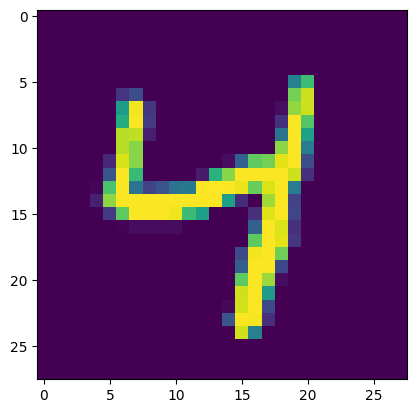

In [ ]:

# Show the image
plt.imshow(test_data[1978][0].reshape(28,28))

In [ ]:
# Pass the image thru our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[1978][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 image


In [ ]:
new_prediction

tensor([[-2.4901e+01, -2.1407e+01, -2.2814e+01, -3.2804e+01, -2.3842e-07,
         -1.7413e+01, -1.5844e+01, -2.3968e+01, -2.9085e+01, -1.6795e+01]])

In [ ]:
new_prediction.argmax()

tensor(4)

## Second Testing

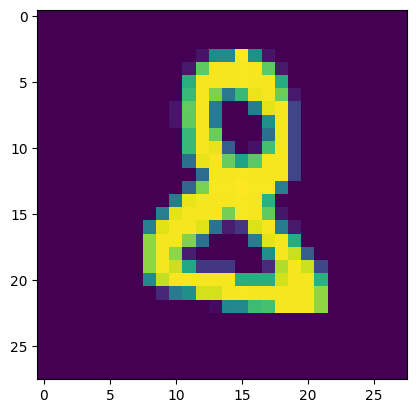

In [ ]:
# Show the image
plt.imshow(test_data[1955][0].reshape(28,28))

In [ ]:
# Pass the image thru our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[1955][0].view(1,1,28,28)) # batch size of 1, 1 color channel, 28x28 image

new_prediction.argmax()

tensor(8)